## Parameter optimization for t-SNE

In [1]:
# Load the "autoreload" extension
%load_ext autoreload

# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd
import hdbscan
import scipy
#Visualisation Libraries
%matplotlib inline
# Uncomment if you want interactive 3D plots --> does not work in the github rendering
#%matplotlib notebook
from copy import deepcopy

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
matplotlib.style.use('ggplot')
import seaborn as sns
# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, 'src')
sys.path.append(src_dir)

%aimport visualization.visualize
from visualization.visualize import get_color_encoding
from visualization.visualize import plot_timeseries_clustering
from visualization.visualize import get_plot_timeseries_clustering_variables
%aimport data.preprocessing
from data.preprocessing import Preprocessor
%aimport data.download
from data.download import DatasetDownloader
%aimport utils.utilities
from utils.utilities import get_cluster_labels

%aimport models.cluster
from models.cluster import get_clustering_performance
%aimport models.dimensionality_reduction
from models.dimensionality_reduction.TSNEModel import TSNEModel
from models.dimensionality_reduction.BayesianTSNEOptimizer import BayesianTSNEOptimizer

Load data from disk.

In [2]:
# Load data from disk.
data_dir = os.path.join(os.path.abspath(DatasetDownloader.get_data_dir()))
file_path = os.path.join(data_dir, "preprocessed","preprocessed_data.dat")
dfs = Preprocessor.restore_preprocessed_data_from_disk(file_path)

Calculate distances.

In [3]:
trips_cut_per_30_sec = Preprocessor.get_cut_trip_snippets_for_total(dfs)
euclidean_distances = Preprocessor.calculate_distance_for_n2(trips_cut_per_30_sec, metric="euclidean")

Prepare distance data for fitting of t-SNE model.

In [4]:
categorical_columns = ["mode", "notes", "scripted", "token", "trip_id"]
segment_distance_matrix = euclidean_distances.drop(categorical_columns,axis=1)

Next steps: Integrate BayesianTSNEOptimizer, start optimization (record results and ingest at next start as initialization values).

In [18]:
# Define parameter ranges, fix static variables.
param_ranges = deepcopy(TSNEModel.PARAMETER_RANGES)
param_ranges["metric"] = (TSNEModel.CATEGORICAL_VALUES["metric"].index("precomputed"),)
param_ranges["init_method"] = (TSNEModel.CATEGORICAL_VALUES["init_method"].index("random"),)
param_ranges["random_state"] = (42,)
param_ranges["n_components"] = (3,)
param_ranges["n_iter"] = (5000,)
#param_ranges["min_grad_norm"] = (0.0000001,)

# Initialize new BO object.
boOpt = BayesianTSNEOptimizer(
    high_dim_data=segment_distance_matrix, 
    cluster_memberships=euclidean_distances["mode"].values, 
    parameters=param_ranges
)

# Load existing results.
history = BayesianTSNEOptimizer.load_result_dict("tsne_results")
if history is not None:
    print("Number of models generated so far: ", len(history["values"]))

# Execute optimization; initialize with existing results.
# Use higher init_fraction if not many initialization datapoints are available.
results = boOpt.run(num_iterations=30, init_fraction=0.1, init_values=history, kappa=6.0)
# Save merged result set (new results and existing ones).
all_results = BayesianTSNEOptimizer.merge_result_dictionaries(results, history)
BayesianTSNEOptimizer.persist_result_dict(
    results=all_results,
    filename="tsne_results"
)

Number of models generated so far:  111
Initialization
-------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     angle |   early_exaggeration |   learning_rate |   min_grad_norm |   perplexity | 
    1 | 00m19s |    0.36532 |    0.7946 |               1.9608 |        410.2173 |          0.0769 |      20.2949 | 
    2 | 00m56s |    0.31999 |    0.4394 |              13.8880 |        811.6344 |          0.0136 |      15.7405 | 
    3 | 00m43s |    0.30678 |    0.3427 |              35.5272 |        886.9313 |          0.0915 |      37.6761 | 
    4 | 00m00s |    0.34443 |    0.3128 |               1.0688 |        654.4796 |          0.0936 |      49.7076 | 
    5 | 00m00s |    0.34637 |    0.3437 |               1.0738 |        562.3034 |          0.0588 |      49.4633 | 
    6 | 00m00s |    0.35604 |    0.8542 |               1.5960 |        464.4792 |          0.0063 |      47.0979 | 
    7 | 00

Bayesian Optimization
-------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |     angle |   early_exaggeration |   learning_rate |   min_grad_norm |   perplexity | 
  115 | 01m20s |    0.35382 |    0.5225 |               1.4387 |        995.3206 |          0.0841 |      49.6596 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 51, 'warnflag': 2, 'grad': array([-0.0006074]), 'nit': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


  116 | 01m20s |    0.35518 |    0.7926 |               1.0639 |        202.1390 |          0.0953 |      31.3576 | 
  117 | 01m15s |    0.35109 |    0.4991 |               1.9649 |        617.5308 |          0.0750 |       5.0730 | 
  118 | 01m41s |    0.34506 |    0.8983 |              18.3409 |        103.3427 |          0.0333 |      46.8847 | 
  119 | 01m11s |    0.36332 |    0.7970 |               1.2872 |        279.7624 |          0.0543 |      13.5962 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 52, 'warnflag': 2, 'grad': array([ 0.00010431]), 'nit': 5, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


  120 | 01m37s |    0.32078 |    0.8592 |              27.5951 |        264.3996 |          0.0195 |      25.9324 | 
  121 | 01m16s |    0.36062 |    0.7959 |               1.2458 |        377.4939 |          0.0269 |      33.3818 | 
  122 | 01m10s |    0.35635 |    0.7336 |               1.0081 |        176.1619 |          0.0403 |       5.7742 | 
  123 | 01m28s |    0.36884 |    0.1067 |              19.6554 |         10.1953 |          0.0966 |      27.3130 | 
  124 | 01m47s |    0.37292 |    0.1593 |              26.3983 |         11.2561 |          0.0696 |       6.2975 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 61, 'warnflag': 2, 'grad': array([-0.0013987]), 'nit': 5, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


  125 | 01m39s |    0.34769 |    0.8195 |              23.2429 |         31.6920 |          0.0342 |       5.0397 | 
  126 | 01m58s |    0.34659 |    0.2436 |               1.0212 |        868.8235 |          0.0237 |      46.5512 | 
  127 | 02m18s |    0.31658 |    0.3717 |              48.6028 |        141.5588 |          0.0413 |      48.5241 | 
  128 | 01m41s |    0.30503 |    0.2065 |              49.7083 |        983.0331 |          0.0999 |      48.7892 | 
  129 | 02m10s |    0.36296 |    0.4171 |               1.1528 |        498.0546 |          0.0044 |      16.1751 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 57, 'warnflag': 2, 'grad': array([-0.00015095]), 'nit': 7, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


  130 | 02m21s |    0.31541 |    0.8776 |              20.8761 |        511.4815 |          0.0085 |      26.6864 | 
  131 | 02m24s |    0.30354 |    0.8012 |              49.9287 |        645.2674 |          0.0854 |       6.4819 | 
  132 | 03m12s |    0.30808 |    0.4117 |              49.9120 |        401.2010 |          0.0228 |      42.8632 | 
  133 | 02m12s |    0.35515 |    0.3288 |               1.1116 |        300.9647 |          0.0719 |      27.9483 | 
  134 | 01m50s |    0.37028 |    0.8322 |              22.4429 |         10.0393 |          0.0876 |       5.5005 | 
  135 | 02m20s |    0.36285 |    0.1217 |               1.1111 |        119.7015 |          0.0005 |      30.6335 | 
  136 | 01m43s |    0.36213 |    0.1518 |               1.6059 |        438.8855 |          0.0714 |      29.1872 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 60, 'warnflag': 2, 'grad': array([-0.0050327]), 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


  137 | 02m41s |    0.31714 |    0.1692 |              16.1068 |        757.1791 |          0.0008 |      49.5965 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


  138 | 01m28s |    0.35630 |    0.8864 |               1.3674 |        959.1041 |          0.0619 |      41.1292 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 51, 'warnflag': 2, 'grad': array([-0.00108346]), 'nit': 2, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


  139 | 02m20s |    0.36639 |    0.2453 |               1.2361 |        389.4502 |          0.0019 |      15.2397 | 
  140 | 01m40s |    0.36074 |    0.3205 |               1.2222 |        246.7941 |          0.0161 |      29.8372 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 60, 'warnflag': 2, 'grad': array([ 0.00059829]), 'nit': 7, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


  141 | 02m28s |    0.32479 |    0.2254 |              49.7400 |         69.9472 |          0.0343 |      49.9872 | 


/home/raphael/Development/datamining/py3env/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'funcalls': 61, 'warnflag': 2, 'grad': array([ 0.00104243]), 'nit': 4, 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH'}
  " state: %s" % convergence_dict)


Sort results by score, pick highest.

In [24]:
all_results_sorted_idx = np.argsort(all_results["values"])
max_score_index = all_results_sorted_idx[-1]
best_param_set = all_results["params"][max_score_index]
print(best_param_set)

{'perplexity': 6.2975330305384913, 'early_exaggeration': 26.398296478695748, 'learning_rate': 11.256126673690892, 'angle': 0.15925222040151887, 'min_grad_norm': 0.069598686192291315}


(Re-)Generate model with given parameter set, since we didn't store the results for each run.

In [22]:
tsne = TSNEModel(num_dimensions=3,
                 perplexity=best_param_set["perplexity"],
                 early_exaggeration=best_param_set["early_exaggeration"],
                 learning_rate=best_param_set["learning_rate"],
                 num_iterations=5000,
                 min_grad_norm=best_param_set["min_grad_norm"],
                 random_state=42,
                 angle=best_param_set["angle"],
                 metric='precomputed',
                 init_method='random')
# Fit t-SNE model.
tsne_results = tsne.run(segment_distance_matrix.values)

Text(0.5,1,'Unscripted')

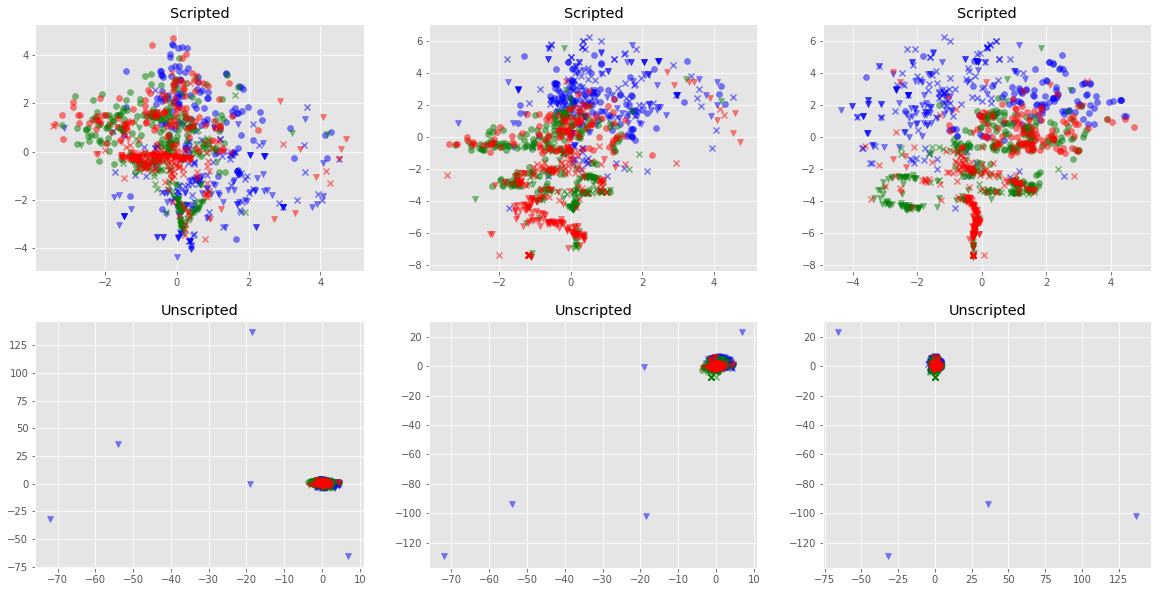

In [23]:
transport_modes = {
    'WALK': 'blue',
    'METRO': 'red',
    'TRAM': 'green'
}
tokens = {
    '355007075245007': 'x',
    '358568053229914': 'o',
    '868049020858898': 'v'
}


fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for transport_mode, transport_mode_color in transport_modes.items():
    transport_mode_scripted = euclidean_distances[
        (euclidean_distances["mode"] == transport_mode) &
        (euclidean_distances["notes"].str.contains('scripted'))
    ]
    transport_mode_unscripted = euclidean_distances[
        (euclidean_distances["mode"] == transport_mode) &
        (~(euclidean_distances["notes"].str.contains('scripted', na=False)))
    ]
    
    for token, token_symbol in tokens.items():
        transport_mode_scripted_for_token = transport_mode_scripted[
            transport_mode_scripted["token"] == token
        ].index.values
        transport_mode_unscripted_for_token = transport_mode_unscripted[
            transport_mode_unscripted["token"] == token
        ].index.values
        
        ax[0, 0].scatter(
            tsne_results[transport_mode_scripted_for_token, 0], 
            tsne_results[transport_mode_scripted_for_token, 1], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )
        ax[0, 1].scatter(
            tsne_results[transport_mode_scripted_for_token, 0], 
            tsne_results[transport_mode_scripted_for_token, 2], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )
        ax[0, 2].scatter(
            tsne_results[transport_mode_scripted_for_token, 1], 
            tsne_results[transport_mode_scripted_for_token, 2], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )
        
        ax[1, 0].scatter(
            tsne_results[transport_mode_unscripted_for_token, 0], 
            tsne_results[transport_mode_unscripted_for_token, 1], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )
        ax[1, 1].scatter(
            tsne_results[transport_mode_unscripted_for_token, 0], 
            tsne_results[transport_mode_unscripted_for_token, 2], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )
        ax[1, 2].scatter(
            tsne_results[transport_mode_unscripted_for_token, 1], 
            tsne_results[transport_mode_unscripted_for_token, 2], 
            c=transport_mode_color, 
            marker=token_symbol, 
            alpha=0.5
        )

ax[0, 0].set_title('Scripted')
ax[0, 1].set_title('Scripted')
ax[0, 2].set_title('Scripted')
ax[1, 0].set_title('Unscripted')
ax[1, 1].set_title('Unscripted')
ax[1, 2].set_title('Unscripted')
#ax[0].legend(loc='upper center', bbox_to_anchor=(1, 0.5))
#ax[1].legend(loc='upper center', bbox_to_anchor=(1, 0.5))